In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
import talib
from talib.abstract import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from tensorflow.random import set_seed
import seaborn as sns
from yellowbrick.regressor import ResidualsPlot, CooksDistance, cooks_distance

pd.options.mode.chained_assignment = None

data = pd.read_csv(".\\att.csv")
data = data[["TICKER","PRC","VOL","OPENPRC","ASKHI","BIDLO","DATE"]]

data.columns = ["Symbol", "CloseUSD","Volume","open","high","low","date"]

att = data.drop(["Symbol"],axis = 1)

att["date"] = pd.to_datetime(att["date"],format = "%Y%m%d")

ModuleNotFoundError: No module named 'pandas'

In [2]:
def addindicators(data):
    df = data.copy()
    df['logret'] = np.log(df.CloseUSD.pct_change()+1)    
    data["1d"] = (np.exp(df["logret"])-1).shift(-1)
        
    data["OBV"] = talib.OBV(data["CloseUSD"], data["Volume"])
    data["SMA25"] = SMA(data["CloseUSD"], timeperiod=25)
    data["SMA12"] = SMA(data["CloseUSD"], timeperiod=12)
    data["SMA100"] = SMA(data["CloseUSD"], timeperiod=100)
    data["RSI"] = RSI(data["CloseUSD"], timeperiod=14)
    data["MACD"] = MACD(data["CloseUSD"], fastperiod=12, slowperiod=26, signalperiod=9)[0]
    data["aroon"] = AROONOSC(data["high"], data["low"], timeperiod=14)
    data["adx"] = ADX(data["high"], data["low"],data["CloseUSD"], timeperiod=14)
    
    return data

def lagit(df,columns, lags = 1):
    df = df.copy()
    for i in range(1,lags+1):
        for column in columns:
            df[column+"_lag_" + str(i)] = df[column].shift(i)
    return df

In [133]:
df = addindicators(att)

df.at[len(df)-1,"1d"] = 0

df = df.drop(["date"],axis = 1)

In [134]:
#prepare for binary
y = df["1d"].apply(lambda x: 1 if (x>0) else 0)
X = df.drop(["1d"],axis = 1)

imputer = KNNImputer(n_neighbors=2)
X = imputer.fit_transform(X)

# poly = PolynomialFeatures(2)
# X = poly.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=5)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

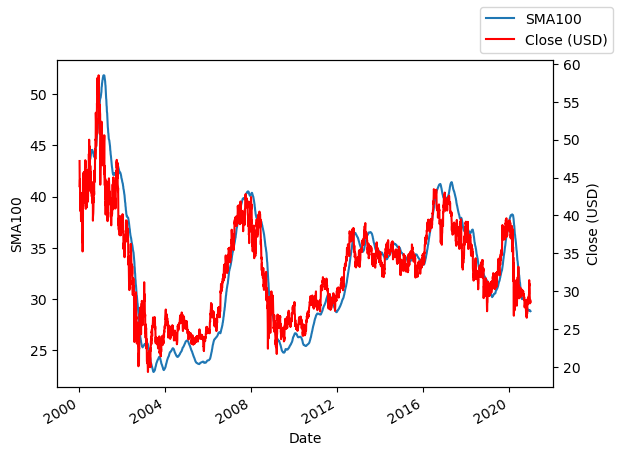

In [52]:
ax = df.plot(x="date", y="SMA100", legend=False)
ax2 = ax.twinx()
df.plot(x="date", y="CloseUSD", ax=ax2, legend=False, color="r").set(ylabel="Close (USD)")
ax.figure.legend(labels=['SMA100','Close (USD)'])
ax.set_ylabel("SMA100")
ax.set_xlabel("Date")
plt.show()

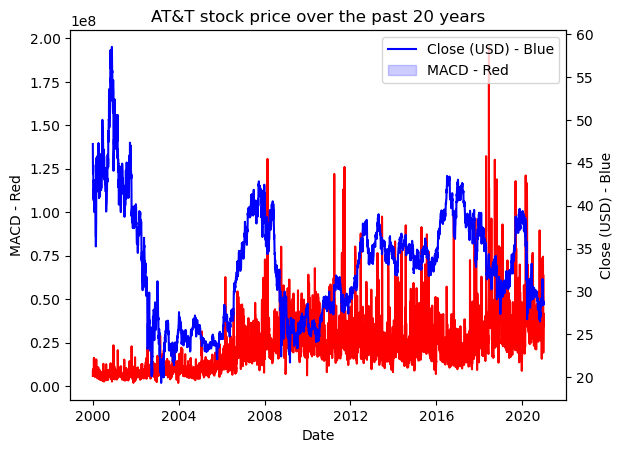

In [56]:
sns.lineplot(x="date", y='Volume', data=df,color = "red").set(title='AT&T stock price over the past 20 years',ylabel="MACD - Red", xlabel = "Date")
ax2 = plt.twinx()
sns.lineplot(x="date", y='CloseUSD', data=df,color = "blue", ax=ax2).set(ylabel = "Close (USD) - Blue" )
plt.legend(labels=['Close (USD) - Blue', 'MACD - Red'])

In [2]:
data["date"] = pd.to_datetime(data["date"],format = "%Y%m%d")
sbc = data[data['Symbol'] == 'SBC']
t = data[data['Symbol'] == 'T']

[Text(0.5, 1.0, 'AT&T stock price over the past 20 years'),
 Text(0, 0.5, 'Close (USD)')]

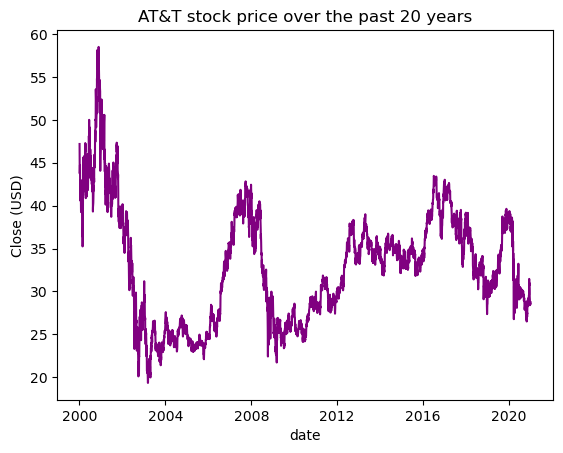

In [3]:
sns.lineplot(x="date", y='CloseUSD', data=att,color = "purple").set(title='AT&T stock price over the past 20 years',ylabel="Close (USD)")

<AxesSubplot:title={'center':'AT&T stock price over the past 20 years'}, xlabel='Date', ylabel='Close (USD)'>

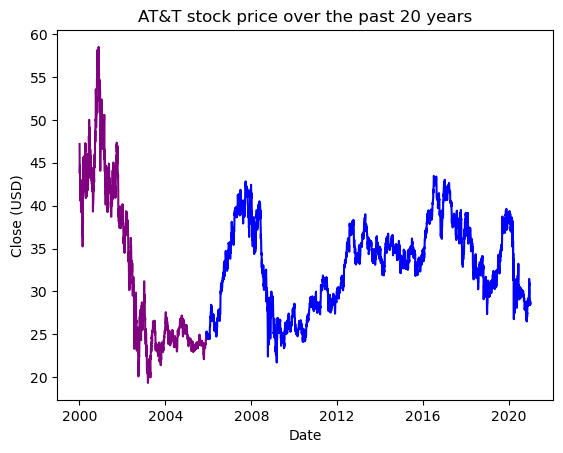

In [5]:
sns.lineplot(x="date", y='CloseUSD', data=sbc,color = "purple").set(title='AT&T stock price over the past 20 years',ylabel="Close (USD)",xlabel = "Date")
sns.lineplot(x="date", y='CloseUSD', data=t,color = "blue")


[Text(0.5, 1.0, 'AT&T stock volume over the past 20 years'),
 Text(0, 0.5, 'Volume'),
 Text(0.5, 0, 'Date')]

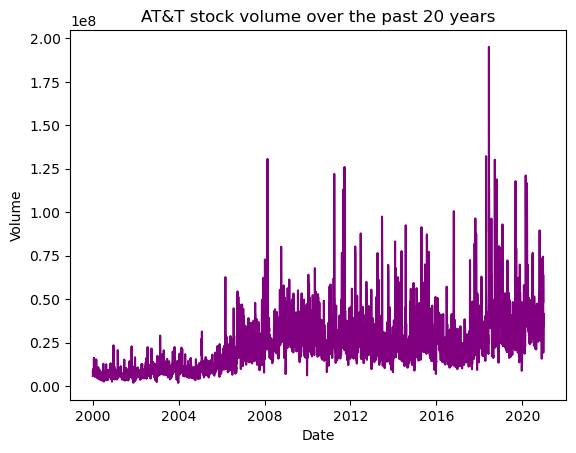

In [55]:
sns.lineplot(x="date", y='Volume', data=df,color = "purple").set(title='AT&T stock volume over the past 20 years',ylabel="Volume",xlabel = "Date")

In [92]:
y

0       79.986111
1       61.887366
2       40.269535
3       41.052780
4       44.296075
          ...    
1025    44.284354
1026    31.178794
1027    23.696601
1028    32.768036
1029    32.401235
Name: strength, Length: 1030, dtype: float64

C:\Users\lucia\AppData\Local\Temp\ipykernel_22932\3423853673.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(temp.corr(), annot=True, cmap='summer')


<AxesSubplot:>

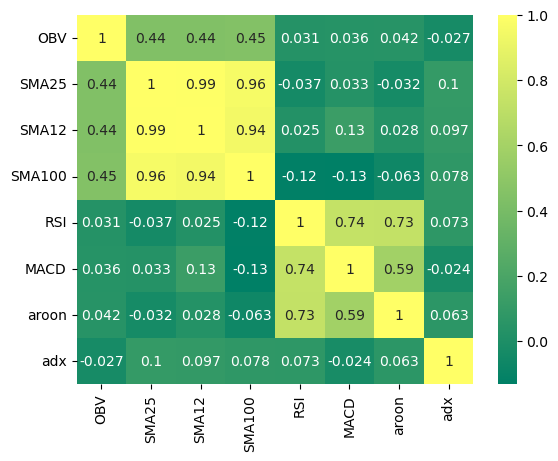

In [59]:
temp = df.drop(["1d","CloseUSD","Volume","open","high","low"],axis=1)

sns.heatmap(temp.corr(), annot=True, cmap='summer')

In [139]:
import statsmodels.api as sm



# fit the model
model = sm.OLS(Y, X)
model = model.fit()

import numpy as np
np.set_printoptions(suppress=True)

# create instance of influence
influence = model.get_influence()

# get Cook's distance for each observation
cooks_distances = influence.cooks_distance

# print Cook's distances
print(cooks_distances)

(array([0.0003317 , 0.00022366, 0.00018261, ..., 0.00017358, 0.00014764,
       0.00018123]), array([1., 1., 1., ..., 1., 1., 1.]))


In [144]:
cooks_distances[0]

array([0.0003317 , 0.00022366, 0.00018261, ..., 0.00017358, 0.00014764,
       0.00018123])

Text(0, 0.5, "Cook's Distance")

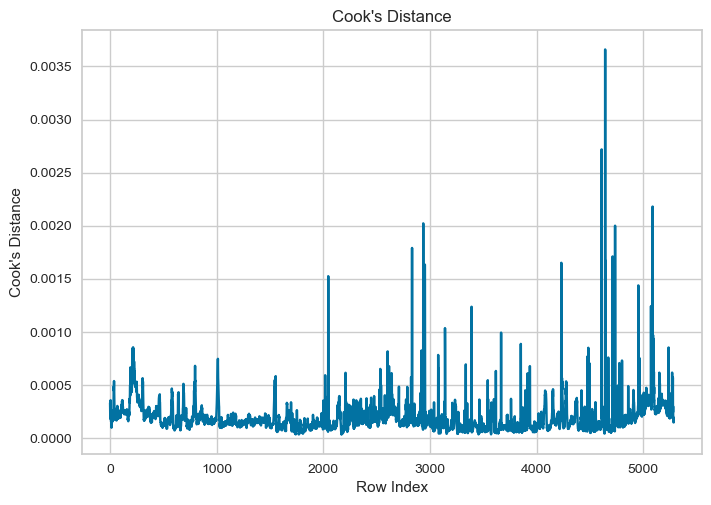

In [156]:
plt.plot(cooks_distances[0])
plt.title("Cook's Distance")
plt.xlabel("Row Index")
plt.ylabel("Cook's Distance")

In [ ]:
#plots the predicted classificaiton and colours the y_test
y_pred = model.predict(X_test).flatten()
y_t = y_test.to_numpy().flatten()


output = pd.DataFrame({"y_pred": y_pred,"y_test": y_t})

output["dummy"] = range(output.index.stop)

In [ ]:
plot = sns.scatterplot(y = "y_pred" ,x = "dummy", data = output, hue = "y_test", palette=["Red","Green"])
plot.axhline(0.5,color = "black")
plot.set_xlabel("Index")